In [1]:
import pickle
import pandas as pd
import re

In [2]:
# Link to original dataset: https://github.com/CrowdTruth/Short-Text-Corpus-For-Humor-Detection/blob/master/datasets/humorous_oneliners.pickle
# git versions changed the Unix new lines ('\n') to DOS lines ('\r\n') so the following step is needed

from library.dos2unixfile import dos2unixfile
dos2unixfile("datasets/original_humorous_oneliners.pickle", "datasets/humorous_oneliners.pickle")

Done. Saved 10502 bytes.


In [3]:
jokes_dataL = pd.read_pickle("datasets/humorous_oneliners.pickle", compression=None)
jokes_data = pd.DataFrame(jokes_dataL, columns = ["joke"])

In [4]:
pd.set_option('display.max_colwidth', -1)
jokes_data.head(10)

,joke
0,"Insanity is hereditary, - You get it from your children."
1,"An honest politician is one who, when bought, stays bought."
2,"You can tune a piano, but you can't tuna fish."
3,A closed mouth gathers no foot.
4,What's black and white and red all over? An embarassed zebra.
5,What's black and white and red all over? Certainly not the Halifax newspapers.
6,Gravity doesn't exist: the earth sucks.
7,What's the most popular form of birth control? The headache.
8,He who laughs last probably doesn't understand the joke.
9,Let him who takes the plunge remember to return it by Tuesday.


In [5]:
# data preprocessing

MIN_JOKE_LEN = 10
MAX_JOKE_LEN = 200

def regex_match(sentence):
    return bool(re.match(r"^[ -z]+$", sentence))

print("Number of jokes originally: ", jokes_data.shape)

# convert to lowercase. Strip left and right whitespaces. Replace multiple spaces with a single space
# Replace odd characters with appropriate ones

clean_jokes_data = (jokes_data
                    .replace('^\-', '', regex=True)
                    .replace('[\t|\r|\n]', ' ', regex=True)
                    .replace("\\\\", ' ', regex=True)
                    .replace("`|´", "'", regex=True)
                    .replace("\u2018|\u2019", "'", regex=True)
                    .replace("\u201C|\u201D", '"', regex=True)
                    .replace("–", '-', regex=True)
                    .replace("…", '...', regex=True)
                    .replace("\&", " and ", regex=True)
                    .replace("\s+", ' ', regex=True)
                    .applymap(str.lower)
                    .applymap(str.strip))

clean_jokes_data = clean_jokes_data[clean_jokes_data["joke"].apply(regex_match) &
                                    (clean_jokes_data["joke"].str.len() >= MIN_JOKE_LEN) & 
                                    (clean_jokes_data["joke"].str.len() <= MAX_JOKE_LEN)]

print("Number of jokes after cleaning: ", clean_jokes_data.shape)
clean_jokes_data.head(10)

Number of jokes originally:  (5251, 1)
Number of jokes after cleaning:  (5218, 1)


,joke
0,"insanity is hereditary, - you get it from your children."
1,"an honest politician is one who, when bought, stays bought."
2,"you can tune a piano, but you can't tuna fish."
3,a closed mouth gathers no foot.
4,what's black and white and red all over? an embarassed zebra.
5,what's black and white and red all over? certainly not the halifax newspapers.
6,gravity doesn't exist: the earth sucks.
7,what's the most popular form of birth control? the headache.
8,he who laughs last probably doesn't understand the joke.
9,let him who takes the plunge remember to return it by tuesday.


In [6]:
unique_chars = sorted(list(set(clean_jokes_data["joke"].str.cat(sep=''))))
print(unique_chars)
print("Number of unique chars = ", len(unique_chars))

[' ', '!', '"', '#', '$', '%', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '=', '?', '@', '^', '_', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
Number of unique chars =  58


In [7]:
# to and fro mapping from characters to indices
START_INDEX = 0
END_INDEX = len(unique_chars) + 1
char_indices = dict((c, i+1) for i, c in enumerate(unique_chars))
indices_char = dict((i+1, c) for i, c in enumerate(unique_chars))
n_letters = len(unique_chars) + 2 # Plus SOS & EOS markers (start and end of sentences)

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1)

In [9]:
def prepare_sequence(seq, to_ix):
    idxs = [START_INDEX] + [to_ix[w] for w in seq] + [END_INDEX]
    return torch.tensor(idxs, dtype=torch.long)

class CharLSTM(nn.Module):
    
    def __init__(self, embedding_dim, hidden_dim, vocab_size, target_size, batch_size):
        super(CharLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        
        self.char_embeddings = nn.Embedding(vocab_size, embedding_dim)
        
        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim
        self.lstm = nn.LSTM(embedding_dim, hidden_dim)
        
        # The linear layer that maps from hidden state space to tag space
        self.hidden2tag = nn.Linear(hidden_dim, target_size)
        self.hidden = self.init_hidden()
        
    def init_hidden(self):
        # Before we've done anything, we dont have any hidden state.
        # Refer to the Pytorch documentation to see exactly
        # why they have this dimensionality.
        # The axes semantics are (num_layers, minibatch_size, hidden_dim)
        return (torch.zeros(1, self.batch_size, self.hidden_dim),
                torch.zeros(1, self.batch_size, self.hidden_dim))

    def forward(self, sentence):
        embeds = self.char_embeddings(sentence)
        x = embeds.view(len(sentence), self.batch_size, -1)
        lstm_out, self.hidden = self.lstm(x, self.hidden)
        tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
        tag_scores = F.log_softmax(tag_space, dim=1)
        return tag_scores

In [10]:
# testing prepare_sequence
joke = clean_jokes_data["joke"].iloc[0]
inputs = prepare_sequence(list(joke), char_indices)
print(joke)
print(char_indices)
print(inputs)

insanity is hereditary, - you get it from your children.
{' ': 1, '!': 2, '"': 3, '#': 4, '$': 5, '%': 6, "'": 7, '(': 8, ')': 9, '*': 10, '+': 11, ',': 12, '-': 13, '.': 14, '/': 15, '0': 16, '1': 17, '2': 18, '3': 19, '4': 20, '5': 21, '6': 22, '7': 23, '8': 24, '9': 25, ':': 26, ';': 27, '=': 28, '?': 29, '@': 30, '^': 31, '_': 32, 'a': 33, 'b': 34, 'c': 35, 'd': 36, 'e': 37, 'f': 38, 'g': 39, 'h': 40, 'i': 41, 'j': 42, 'k': 43, 'l': 44, 'm': 45, 'n': 46, 'o': 47, 'p': 48, 'q': 49, 'r': 50, 's': 51, 't': 52, 'u': 53, 'v': 54, 'w': 55, 'x': 56, 'y': 57, 'z': 58}
tensor([  0,  41,  46,  51,  33,  46,  41,  52,  57,   1,  41,  51,
          1,  40,  37,  50,  37,  36,  41,  52,  33,  50,  57,  12,
          1,  13,   1,  57,  47,  53,   1,  39,  37,  52,   1,  41,
         52,   1,  38,  50,  47,  45,   1,  57,  47,  53,  50,   1,
         35,  40,  41,  44,  36,  50,  37,  46,  14,  59])


In [11]:
EMBEDDING_DIM = 32
HIDDEN_DIM = 64
BATCH_SIZE = 1
VOCAB_SIZE = n_letters
model = CharLSTM(EMBEDDING_DIM, HIDDEN_DIM, VOCAB_SIZE, VOCAB_SIZE, BATCH_SIZE)
loss_function = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.1)

In [12]:
with torch.no_grad():
    inputs = prepare_sequence(list(joke), char_indices)
    tag_scores = model(inputs)
    print(tag_scores)

tensor([[-4.0980, -3.9963, -4.2156,  ..., -4.1599, -4.0525, -4.0420],
        [-4.0825, -3.9655, -4.1046,  ..., -4.1561, -4.0493, -4.1139],
        [-4.1239, -4.0883, -4.1711,  ..., -4.0700, -3.9779, -4.1173],
        ...,
        [-4.0763, -4.1162, -4.1881,  ..., -4.0598, -3.9594, -4.1122],
        [-4.0773, -4.1022, -4.1655,  ..., -4.2042, -4.0117, -4.1081],
        [-4.0384, -4.0719, -4.0964,  ..., -4.1367, -3.9341, -4.1614]])


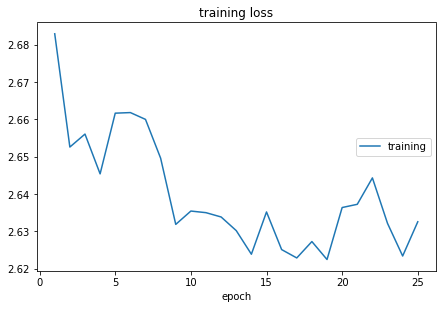

In [15]:
import random
from livelossplot import PlotLosses
from tqdm import tqdm

NUM_EPOCHS = 25
# prepare training data in correct form
jokes_to_chars = [list(joke) for joke in clean_jokes_data["joke"].values.tolist()]
jokes_to_seq = [prepare_sequence(joke, char_indices) for joke in jokes_to_chars]
training_data = [(seq[:-1], seq[1:]) for seq in jokes_to_seq]
#training_data = training_data[:100]
#print(training_data)

liveloss = None
train_loss = []
for epoch in range(NUM_EPOCHS):
    print("epoch#", epoch+1)
    
    # Shuffle training data
    random.shuffle(training_data)
    
    total_loss = 0.0
    
    for sentence_in, sentence_out in tqdm(training_data):
        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        model.zero_grad()

        # Also, we need to clear out the hidden state of the LSTM,
        # detaching it from its history on the last instance.
        model.hidden = model.init_hidden()
        
        # Step 3. Run our forward pass.
        tag_scores = model(sentence_in)
        
        # Step 4. Compute the loss, gradients, and update the parameters by
        #  calling optimizer.step()
        loss = loss_function(tag_scores, sentence_out)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.data[0]
    avg_loss = total_loss/len(training_data)
    train_loss.append(avg_loss)
    
    if liveloss is None:
        liveloss = PlotLosses()
    liveloss.update({
        'training loss': avg_loss
    })
    liveloss.draw()